In [1]:
#importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.model_selection import GridSearchCV
from math import sqrt
import pickle

In [2]:
data = pd.read_csv('Data review - Sheet1.csv')

In [3]:
data

,Unnamed: 0,DEPTH (FT AH),SG (Oil Gravity) @ 60/60F,API,"Viscosity @ SC, cSt","Temp (deg F, res)","Viscosity @ RC, cp",Pressure,"Uob, cp","Uo, cp"
0,NaN,6989,0.95,17.8,121.00,126,13.0,2890,14.0,14.0
1,NaN,6989,0.95,17.8,112.60,126,13.0,2890,14.0,14.0
2,NaN,6989,0.95,18.3,127.30,126,14.0,2890,15.0,15.0
3,NaN,6994,0.95,18.0,114.60,126,13.0,2890,14.0,14.0
4,NaN,6994,0.95,17.9,113.90,126,13.0,2890,14.0,14.0
...,...,...,...,...,...,...,...,...,...,...
357,NaN,9820,0.91,23.3,17.32,171,5.1,4200,11.0,25.0
358,NaN,9820,0.92,22.5,20.04,171,5.9,4200,12.0,28.0
359,NaN,10544,0.82,40.2,2.82,191,0.9,4500,2.1,6.7
360,NaN,10135,0.83,38.9,2.86,191,0.9,4500,1.0,1.2


In [4]:
data.columns

Index(['Unnamed: 0', 'DEPTH (FT AH)', 'SG (Oil Gravity) @ 60/60F', 'API',
       'Viscosity @ SC, cSt', 'Temp (deg F, res)', 'Viscosity @ RC, cp',
       'Pressure', 'Uob, cp', 'Uo, cp'],
      dtype='object')

In [5]:
data = data.drop(['Unnamed: 0', 'Uo, cp'], axis = 1)

In [6]:
data

,DEPTH (FT AH),SG (Oil Gravity) @ 60/60F,API,"Viscosity @ SC, cSt","Temp (deg F, res)","Viscosity @ RC, cp",Pressure,"Uob, cp"
0,6989,0.95,17.8,121.00,126,13.0,2890,14.0
1,6989,0.95,17.8,112.60,126,13.0,2890,14.0
2,6989,0.95,18.3,127.30,126,14.0,2890,15.0
3,6994,0.95,18.0,114.60,126,13.0,2890,14.0
4,6994,0.95,17.9,113.90,126,13.0,2890,14.0
...,...,...,...,...,...,...,...,...
357,9820,0.91,23.3,17.32,171,5.1,4200,11.0
358,9820,0.92,22.5,20.04,171,5.9,4200,12.0
359,10544,0.82,40.2,2.82,191,0.9,4500,2.1
360,10135,0.83,38.9,2.86,191,0.9,4500,1.0


In [ ]:
def _generate_indices(random_state, bootstrap, n_population, n_samples):
    """Draw randomly sampled indices."""
    # Draw sample indices
    if bootstrap:
        indices = random_state.randint(0, n_population, n_samples)
    else:
        indices = sample_without_replacement(n_population, n_samples,
                                             random_state=random_state)

    return indices


def _generate_bagging_indices(random_state, bootstrap_features,
                              bootstrap_samples, n_features, n_samples,
                              max_features, max_samples):
    """Randomly draw feature and sample indices."""
    # Get valid random state
    random_state = check_random_state(random_state)

    # Draw indices
    feature_indices = _generate_indices(random_state, bootstrap_features,
                                        n_features, max_features)
    sample_indices = _generate_indices(random_state, bootstrap_samples,
                                       n_samples, max_samples)

    return feature_indices, sample_indices


def _parallel_build_estimators(n_estimators, ensemble, X, y, sample_weight,
                               seeds, total_n_estimators, verbose):
    """Private function used to build a batch of estimators within a job."""
    # Retrieve settings
    n_samples, n_features = X.shape
    max_features = ensemble._max_features
    max_samples = ensemble._max_samples
    bootstrap = ensemble.bootstrap
    bootstrap_features = ensemble.bootstrap_features
    support_sample_weight = has_fit_parameter(ensemble.base_estimator_,
                                              "sample_weight")
    if not support_sample_weight and sample_weight is not None:
        raise ValueError("The base estimator doesn't support sample weight")

    # Build estimators
    estimators = []
    estimators_features = []

    for i in range(n_estimators):
        if verbose > 1:
            print("Building estimator %d of %d for this parallel run "
                  "(total %d)..." % (i + 1, n_estimators, total_n_estimators))

        random_state = seeds[i]
        estimator = ensemble._make_estimator(append=False,
                                             random_state=random_state)

        # Draw random feature, sample indices
        features, indices = _generate_bagging_indices(random_state,
                                                      bootstrap_features,
                                                      bootstrap, n_features,
                                                      n_samples, max_features,
                                                      max_samples)

        # Draw samples, using sample weights, and then fit
        if support_sample_weight:
            if sample_weight is None:
                curr_sample_weight = np.ones((n_samples,))
            else:
                curr_sample_weight = sample_weight.copy()

            if bootstrap:
                sample_counts = np.bincount(indices, minlength=n_samples)
                curr_sample_weight *= sample_counts
            else:
                not_indices_mask = ~indices_to_mask(indices, n_samples)
                curr_sample_weight[not_indices_mask] = 0

            estimator.fit(X[:, features], y, sample_weight=curr_sample_weight)

        else:
            estimator.fit((X[indices])[:, features], y[indices])

        estimators.append(estimator)
        estimators_features.append(features)

    return estimators, estimators_features


def _parallel_predict_proba(estimators, estimators_features, X, n_classes):
    """Private function used to compute (proba-)predictions within a job."""
    n_samples = X.shape[0]
    proba = np.zeros((n_samples, n_classes))

    for estimator, features in zip(estimators, estimators_features):
        if hasattr(estimator, "predict_proba"):
            proba_estimator = estimator.predict_proba(X[:, features])

            if n_classes == len(estimator.classes_):
                proba += proba_estimator

            else:
                proba[:, estimator.classes_] += \
                    proba_estimator[:, range(len(estimator.classes_))]

        else:
            # Resort to voting
            predictions = estimator.predict(X[:, features])

            for i in range(n_samples):
                proba[i, predictions[i]] += 1

    return proba


def _parallel_predict_log_proba(estimators, estimators_features, X, n_classes):
    """Private function used to compute log probabilities within a job."""
    n_samples = X.shape[0]
    log_proba = np.empty((n_samples, n_classes))
    log_proba.fill(-np.inf)
    all_classes = np.arange(n_classes, dtype=np.int)

    for estimator, features in zip(estimators, estimators_features):
        log_proba_estimator = estimator.predict_log_proba(X[:, features])

        if n_classes == len(estimator.classes_):
            log_proba = np.logaddexp(log_proba, log_proba_estimator)

        else:
            log_proba[:, estimator.classes_] = np.logaddexp(
                log_proba[:, estimator.classes_],
                log_proba_estimator[:, range(len(estimator.classes_))])

            missing = np.setdiff1d(all_classes, estimator.classes_)
            log_proba[:, missing] = np.logaddexp(log_proba[:, missing],
                                                 -np.inf)

    return log_proba


def _parallel_decision_function(estimators, estimators_features, X):
    """Private function used to compute decisions within a job."""
    return sum(estimator.decision_function(X[:, features])
               for estimator, features in zip(estimators,
                                              estimators_features))


def _parallel_predict_regression(estimators, estimators_features, X):
    """Private function used to compute predictions within a job."""
    return sum(estimator.predict(X[:, features])
               for estimator, features in zip(estimators,
                                              estimators_features))


In [ ]:
def _parallel_predict_log_proba(estimators, estimators_features, X, n_classes):
    """Private function used to compute log probabilities within a job."""
    n_samples = X.shape[0]
    log_proba = np.empty((n_samples, n_classes))
    log_proba.fill(-np.inf)
    all_classes = np.arange(n_classes, dtype=np.int)

    for estimator, features in zip(estimators, estimators_features):
        log_proba_estimator = estimator.predict_log_proba(X[:, features])

        if n_classes == len(estimator.classes_):
            log_proba = np.logaddexp(log_proba, log_proba_estimator)

        else:
            log_proba[:, estimator.classes_] = np.logaddexp(
                log_proba[:, estimator.classes_],
                log_proba_estimator[:, range(len(estimator.classes_))])

            missing = np.setdiff1d(all_classes, estimator.classes_)
            log_proba[:, missing] = np.logaddexp(log_proba[:, missing],
                                                 -np.inf)

    return log_proba


def _parallel_decision_function(estimators, estimators_features, X):
    """Private function used to compute decisions within a job."""
    return sum(estimator.decision_function(X[:, features])
               for estimator, features in zip(estimators,
                                              estimators_features))


def _parallel_predict_regression(estimators, estimators_features, X):
    """Private function used to compute predictions within a job."""
    return sum(estimator.predict(X[:, features])
               for estimator, features in zip(estimators,
                                              estimators_features))


class BaseBagging(BaseEnsemble, metaclass=ABCMeta):
    """Base class for Bagging meta-estimator.
    Warning: This class should not be used directly. Use derived classes
    instead.
    """

    @abstractmethod
    def __init__(self,
                 base_estimator=None,
                 n_estimators=10,
                 max_samples=1.0,
                 max_features=1.0,
                 bootstrap=True,
                 bootstrap_features=False,
                 oob_score=False,
                 warm_start=False,
                 n_jobs=None,
                 random_state=None,
                 verbose=0):
        super().__init__(
            base_estimator=base_estimator,
            n_estimators=n_estimators)

        self.max_samples = max_samples
        self.max_features = max_features
        self.bootstrap = bootstrap
        self.bootstrap_features = bootstrap_features
        self.oob_score = oob_score
        self.warm_start = warm_start
        self.n_jobs = n_jobs
        self.random_state = random_state
        self.verbose = verbose

    def fit(self, X, y, sample_weight=None):
        """Build a Bagging ensemble of estimators from the training
           set (X, y).
        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            The training input samples. Sparse matrices are accepted only if
            they are supported by the base estimator.
        y : array-like of shape (n_samples,)
            The target values (class labels in classification, real numbers in
            regression).
        sample_weight : array-like of shape (n_samples,), default=None
            Sample weights. If None, then samples are equally weighted.
            Note that this is supported only if the base estimator supports
            sample weighting.
        Returns
        -------
        self : object
        """
        return self._fit(X, y, self.max_samples, sample_weight=sample_weight)

    def _parallel_args(self):
        return {}

    def _fit(self, X, y, max_samples=None, max_depth=None, sample_weight=None):
        """Build a Bagging ensemble of estimators from the training
           set (X, y).
        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            The training input samples. Sparse matrices are accepted only if
            they are supported by the base estimator.
        y : array-like of shape (n_samples,)
            The target values (class labels in classification, real numbers in
            regression).
        max_samples : int or float, default=None
            Argument to use instead of self.max_samples.
        max_depth : int, default=None
            Override value used when constructing base estimator. Only
            supported if the base estimator has a max_depth parameter.
        sample_weight : array-like of shape (n_samples,), default=None
            Sample weights. If None, then samples are equally weighted.
            Note that this is supported only if the base estimator supports
            sample weighting.
        Returns
        -------
        self : object
        """
        random_state = check_random_state(self.random_state)

        # Convert data (X is required to be 2d and indexable)
        X, y = self._validate_data(
            X, y, accept_sparse=['csr', 'csc'], dtype=None,
            force_all_finite=False, multi_output=True
        )
        if sample_weight is not None:
            sample_weight = _check_sample_weight(sample_weight, X, dtype=None)

        # Remap output
        n_samples, self.n_features_ = X.shape
        self._n_samples = n_samples
        y = self._validate_y(y)

        # Check parameters
        self._validate_estimator()

        if max_depth is not None:
            self.base_estimator_.max_depth = max_depth

        # Validate max_samples
        if max_samples is None:
            max_samples = self.max_samples
        elif not isinstance(max_samples, numbers.Integral):
            max_samples = int(max_samples * X.shape[0])

        if not (0 < max_samples <= X.shape[0]):
            raise ValueError("max_samples must be in (0, n_samples]")

        # Store validated integer row sampling value
        self._max_samples = max_samples

        # Validate max_features
        if isinstance(self.max_features, numbers.Integral):
            max_features = self.max_features
        elif isinstance(self.max_features, np.float):
            max_features = self.max_features * self.n_features_
        else:
            raise ValueError("max_features must be int or float")

        if not (0 < max_features <= self.n_features_):
            raise ValueError("max_features must be in (0, n_features]")

        max_features = max(1, int(max_features))

        # Store validated integer feature sampling value
        self._max_features = max_features

        # Other checks
        if not self.bootstrap and self.oob_score:
            raise ValueError("Out of bag estimation only available"
                             " if bootstrap=True")

        if self.warm_start and self.oob_score:
            raise ValueError("Out of bag estimate only available"
                             " if warm_start=False")

        if hasattr(self, "oob_score_") and self.warm_start:
            del self.oob_score_

        if not self.warm_start or not hasattr(self, 'estimators_'):
            # Free allocated memory, if any
            self.estimators_ = []
            self.estimators_features_ = []

        n_more_estimators = self.n_estimators - len(self.estimators_)

        if n_more_estimators < 0:
            raise ValueError('n_estimators=%d must be larger or equal to '
                             'len(estimators_)=%d when warm_start==True'
                             % (self.n_estimators, len(self.estimators_)))

        elif n_more_estimators == 0:
            warn("Warm-start fitting without increasing n_estimators does not "
                 "fit new trees.")
            return self

        # Parallel loop
        n_jobs, n_estimators, starts = _partition_estimators(n_more_estimators,
                                                             self.n_jobs)
        total_n_estimators = sum(n_estimators)

        # Advance random state to state after training
        # the first n_estimators
        if self.warm_start and len(self.estimators_) > 0:
            random_state.randint(MAX_INT, size=len(self.estimators_))

        seeds = random_state.randint(MAX_INT, size=n_more_estimators)
        self._seeds = seeds

        all_results = Parallel(n_jobs=n_jobs, verbose=self.verbose,
                               **self._parallel_args())(
            delayed(_parallel_build_estimators)(
                n_estimators[i],
                self,
                X,
                y,
                sample_weight,
                seeds[starts[i]:starts[i + 1]],
                total_n_estimators,
                verbose=self.verbose)
            for i in range(n_jobs))

        # Reduce
        self.estimators_ += list(itertools.chain.from_iterable(
            t[0] for t in all_results))
        self.estimators_features_ += list(itertools.chain.from_iterable(
            t[1] for t in all_results))

        if self.oob_score:
            self._set_oob_score(X, y)

        return self

    @abstractmethod
    def _set_oob_score(self, X, y):
        """Calculate out of bag predictions and score."""

    def _validate_y(self, y):
        if len(y.shape) == 1 or y.shape[1] == 1:
            return column_or_1d(y, warn=True)
        else:
            return y

    def _get_estimators_indices(self):
        # Get drawn indices along both sample and feature axes
        for seed in self._seeds:
            # Operations accessing random_state must be performed identically
            # to those in `_parallel_build_estimators()`
            feature_indices, sample_indices = _generate_bagging_indices(
                seed, self.bootstrap_features, self.bootstrap,
                self.n_features_, self._n_samples, self._max_features,
                self._max_samples)

            yield feature_indices, sample_indices

    @property
    def estimators_samples_(self):
        """
        The subset of drawn samples for each base estimator.
        Returns a dynamically generated list of indices identifying
        the samples used for fitting each member of the ensemble, i.e.,
        the in-bag samples.
        Note: the list is re-created at each call to the property in order
        to reduce the object memory footprint by not storing the sampling
        data. Thus fetching the property may be slower than expected.
        """
        return [sample_indices
                for _, sample_indices in self._get_estimators_indices()]


In [ ]:
class BaggingClassifier(ClassifierMixin, BaseBagging):
    """A Bagging classifier.
    A Bagging classifier is an ensemble meta-estimator that fits base
    classifiers each on random subsets of the original dataset and then
    aggregate their individual predictions (either by voting or by averaging)
    to form a final prediction. Such a meta-estimator can typically be used as
    a way to reduce the variance of a black-box estimator (e.g., a decision
    tree), by introducing randomization into its construction procedure and
    then making an ensemble out of it.
    This algorithm encompasses several works from the literature. When random
    subsets of the dataset are drawn as random subsets of the samples, then
    this algorithm is known as Pasting [1]_. If samples are drawn with
    replacement, then the method is known as Bagging [2]_. When random subsets
    of the dataset are drawn as random subsets of the features, then the method
    is known as Random Subspaces [3]_. Finally, when base estimators are built
    on subsets of both samples and features, then the method is known as
    Random Patches [4]_.
    Read more in the :ref:`User Guide <bagging>`.
    .. versionadded:: 0.15
    Parameters
    ----------
    base_estimator : object, default=None
        The base estimator to fit on random subsets of the dataset.
        If None, then the base estimator is a decision tree.
    n_estimators : int, default=10
        The number of base estimators in the ensemble.
    max_samples : int or float, default=1.0
        The number of samples to draw from X to train each base estimator (with
        replacement by default, see `bootstrap` for more details).
        - If int, then draw `max_samples` samples.
        - If float, then draw `max_samples * X.shape[0]` samples.
    max_features : int or float, default=1.0
        The number of features to draw from X to train each base estimator (
        without replacement by default, see `bootstrap_features` for more
        details).
        - If int, then draw `max_features` features.
        - If float, then draw `max_features * X.shape[1]` features.
    bootstrap : bool, default=True
        Whether samples are drawn with replacement. If False, sampling
        without replacement is performed.
    bootstrap_features : bool, default=False
        Whether features are drawn with replacement.
    oob_score : bool, default=False
        Whether to use out-of-bag samples to estimate
        the generalization error.
    warm_start : bool, default=False
        When set to True, reuse the solution of the previous call to fit
        and add more estimators to the ensemble, otherwise, just fit
        a whole new ensemble. See :term:`the Glossary <warm_start>`.
        .. versionadded:: 0.17
           *warm_start* constructor parameter.
    n_jobs : int, default=None
        The number of jobs to run in parallel for both :meth:`fit` and
        :meth:`predict`. ``None`` means 1 unless in a
        :obj:`joblib.parallel_backend` context. ``-1`` means using all
        processors. See :term:`Glossary <n_jobs>` for more details.
    random_state : int or RandomState, default=None
        Controls the random resampling of the original dataset
        (sample wise and feature wise).
        If the base estimator accepts a `random_state` attribute, a different
        seed is generated for each instance in the ensemble.
        Pass an int for reproducible output across multiple function calls.
        See :term:`Glossary <random_state>`.
    verbose : int, default=0
        Controls the verbosity when fitting and predicting.
    Attributes
    ----------
    base_estimator_ : estimator
        The base estimator from which the ensemble is grown.
    n_features_ : int
        The number of features when :meth:`fit` is performed.
    estimators_ : list of estimators
        The collection of fitted base estimators.
    estimators_samples_ : list of arrays
        The subset of drawn samples (i.e., the in-bag samples) for each base
        estimator. Each subset is defined by an array of the indices selected.
    estimators_features_ : list of arrays
        The subset of drawn features for each base estimator.
    classes_ : ndarray of shape (n_classes,)
        The classes labels.
    n_classes_ : int or list
        The number of classes.
    oob_score_ : float
        Score of the training dataset obtained using an out-of-bag estimate.
        This attribute exists only when ``oob_score`` is True.
    oob_decision_function_ : ndarray of shape (n_samples, n_classes)
        Decision function computed with out-of-bag estimate on the training
        set. If n_estimators is small it might be possible that a data point
        was never left out during the bootstrap. In this case,
        `oob_decision_function_` might contain NaN. This attribute exists
        only when ``oob_score`` is True.
    Examples
    --------
    >>> from sklearn.svm import SVC
    >>> from sklearn.ensemble import BaggingClassifier
    >>> from sklearn.datasets import make_classification
    >>> X, y = make_classification(n_samples=100, n_features=4,
    ...                            n_informative=2, n_redundant=0,
    ...                            random_state=0, shuffle=False)
    >>> clf = BaggingClassifier(base_estimator=SVC(),
    ...                         n_estimators=10, random_state=0).fit(X, y)
    >>> clf.predict([[0, 0, 0, 0]])
    array([1])
    References
    ----------
    .. [1] L. Breiman, "Pasting small votes for classification in large
           databases and on-line", Machine Learning, 36(1), 85-103, 1999.
    .. [2] L. Breiman, "Bagging predictors", Machine Learning, 24(2), 123-140,
           1996.
    .. [3] T. Ho, "The random subspace method for constructing decision
           forests", Pattern Analysis and Machine Intelligence, 20(8), 832-844,
           1998.
    .. [4] G. Louppe and P. Geurts, "Ensembles on Random Patches", Machine
           Learning and Knowledge Discovery in Databases, 346-361, 2012.
    """
    def __init__(self,
                 base_estimator=None,
                 n_estimators=10,
                 max_samples=1.0,
                 max_features=1.0,
                 bootstrap=True,
                 bootstrap_features=False,
                 oob_score=False,
                 warm_start=False,
                 n_jobs=None,
                 random_state=None,
                 verbose=0):

        super().__init__(
            base_estimator,
            n_estimators=n_estimators,
            max_samples=max_samples,
            max_features=max_features,
            bootstrap=bootstrap,
            bootstrap_features=bootstrap_features,
            oob_score=oob_score,
            warm_start=warm_start,
            n_jobs=n_jobs,
            random_state=random_state,
            verbose=verbose)

    def _validate_estimator(self):
        """Check the estimator and set the base_estimator_ attribute."""
        super()._validate_estimator(
            default=DecisionTreeClassifier())

    def _set_oob_score(self, X, y):
        n_samples = y.shape[0]
        n_classes_ = self.n_classes_

        predictions = np.zeros((n_samples, n_classes_))

        for estimator, samples, features in zip(self.estimators_,
                                                self.estimators_samples_,
                                                self.estimators_features_):
            # Create mask for OOB samples
            mask = ~indices_to_mask(samples, n_samples)

            if hasattr(estimator, "predict_proba"):
                predictions[mask, :] += estimator.predict_proba(
                    (X[mask, :])[:, features])

            else:
                p = estimator.predict((X[mask, :])[:, features])
                j = 0

                for i in range(n_samples):
                    if mask[i]:
                        predictions[i, p[j]] += 1
                        j += 1

        if (predictions.sum(axis=1) == 0).any():
            warn("Some inputs do not have OOB scores. "
                 "This probably means too few estimators were used "
                 "to compute any reliable oob estimates.")

        oob_decision_function = (predictions /
                                 predictions.sum(axis=1)[:, np.newaxis])
        oob_score = accuracy_score(y, np.argmax(predictions, axis=1))

        self.oob_decision_function_ = oob_decision_function
        self.oob_score_ = oob_score

    def _validate_y(self, y):
        y = column_or_1d(y, warn=True)
        check_classification_targets(y)
        self.classes_, y = np.unique(y, return_inverse=True)
        self.n_classes_ = len(self.classes_)

        return y

    def predict(self, X):
        """Predict class for X.
        The predicted class of an input sample is computed as the class with
        the highest mean predicted probability. If base estimators do not
        implement a ``predict_proba`` method, then it resorts to voting.
        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            The training input samples. Sparse matrices are accepted only if
            they are supported by the base estimator.
        Returns
        -------
        y : ndarray of shape (n_samples,)
            The predicted classes.
        """
        predicted_probabilitiy = self.predict_proba(X)
        return self.classes_.take((np.argmax(predicted_probabilitiy, axis=1)),
                                  axis=0)

    def predict_proba(self, X):
        """Predict class probabilities for X.
        The predicted class probabilities of an input sample is computed as
        the mean predicted class probabilities of the base estimators in the
        ensemble. If base estimators do not implement a ``predict_proba``
        method, then it resorts to voting and the predicted class probabilities
        of an input sample represents the proportion of estimators predicting
        each class.
        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            The training input samples. Sparse matrices are accepted only if
            they are supported by the base estimator.
        Returns
        -------
        p : ndarray of shape (n_samples, n_classes)
            The class probabilities of the input samples. The order of the
            classes corresponds to that in the attribute :term:`classes_`.
        """
        check_is_fitted(self)
        # Check data
        X = check_array(
            X, accept_sparse=['csr', 'csc'], dtype=None,
            force_all_finite=False
        )

        if self.n_features_ != X.shape[1]:
            raise ValueError("Number of features of the model must "
                             "match the input. Model n_features is {0} and "
                             "input n_features is {1}."
                             "".format(self.n_features_, X.shape[1]))

        # Parallel loop
        n_jobs, n_estimators, starts = _partition_estimators(self.n_estimators,
                                                             self.n_jobs)

        all_proba = Parallel(n_jobs=n_jobs, verbose=self.verbose,
                             **self._parallel_args())(
            delayed(_parallel_predict_proba)(
                self.estimators_[starts[i]:starts[i + 1]],
                self.estimators_features_[starts[i]:starts[i + 1]],
                X,
                self.n_classes_)
            for i in range(n_jobs))

        # Reduce
        proba = sum(all_proba) / self.n_estimators

        return proba

    def predict_log_proba(self, X):
        """Predict class log-probabilities for X.
        The predicted class log-probabilities of an input sample is computed as
        the log of the mean predicted class probabilities of the base
        estimators in the ensemble.
        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            The training input samples. Sparse matrices are accepted only if
            they are supported by the base estimator.
        Returns
        -------
        p : ndarray of shape (n_samples, n_classes)
            The class log-probabilities of the input samples. The order of the
            classes corresponds to that in the attribute :term:`classes_`.
        """
        check_is_fitted(self)
        if hasattr(self.base_estimator_, "predict_log_proba"):
            # Check data
            X = check_array(
                X, accept_sparse=['csr', 'csc'], dtype=None,
                force_all_finite=False
            )

            if self.n_features_ != X.shape[1]:
                raise ValueError("Number of features of the model must "
                                 "match the input. Model n_features is {0} "
                                 "and input n_features is {1} "
                                 "".format(self.n_features_, X.shape[1]))

            # Parallel loop
            n_jobs, n_estimators, starts = _partition_estimators(
                self.n_estimators, self.n_jobs)

            all_log_proba = Parallel(n_jobs=n_jobs, verbose=self.verbose)(
                delayed(_parallel_predict_log_proba)(
                    self.estimators_[starts[i]:starts[i + 1]],
                    self.estimators_features_[starts[i]:starts[i + 1]],
                    X,
                    self.n_classes_)
                for i in range(n_jobs))

            # Reduce
            log_proba = all_log_proba[0]

            for j in range(1, len(all_log_proba)):
                log_proba = np.logaddexp(log_proba, all_log_proba[j])

            log_proba -= np.log(self.n_estimators)

            return log_proba

        else:
            return np.log(self.predict_proba(X))

    @if_delegate_has_method(delegate='base_estimator')
    def decision_function(self, X):
        """Average of the decision functions of the base classifiers.
        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            The training input samples. Sparse matrices are accepted only if
            they are supported by the base estimator.
        Returns
        -------
        score : ndarray of shape (n_samples, k)
            The decision function of the input samples. The columns correspond
            to the classes in sorted order, as they appear in the attribute
            ``classes_``. Regression and binary classification are special
            cases with ``k == 1``, otherwise ``k==n_classes``.
        """
        check_is_fitted(self)

        # Check data
        X = check_array(
            X, accept_sparse=['csr', 'csc'], dtype=None,
            force_all_finite=False
        )

        if self.n_features_ != X.shape[1]:
            raise ValueError("Number of features of the model must "
                             "match the input. Model n_features is {0} and "
                             "input n_features is {1} "
                             "".format(self.n_features_, X.shape[1]))

        # Parallel loop
        n_jobs, n_estimators, starts = _partition_estimators(self.n_estimators,
                                                             self.n_jobs)

        all_decisions = Parallel(n_jobs=n_jobs, verbose=self.verbose)(
            delayed(_parallel_decision_function)(
                self.estimators_[starts[i]:starts[i + 1]],
                self.estimators_features_[starts[i]:starts[i + 1]],
                X)
            for i in range(n_jobs))

        # Reduce
        decisions = sum(all_decisions) / self.n_estimators

        return decisions


class BaggingRegressor(RegressorMixin, BaseBagging):
    """A Bagging regressor.
    A Bagging regressor is an ensemble meta-estimator that fits base
    regressors each on random subsets of the original dataset and then
    aggregate their individual predictions (either by voting or by averaging)
    to form a final prediction. Such a meta-estimator can typically be used as
    a way to reduce the variance of a black-box estimator (e.g., a decision
    tree), by introducing randomization into its construction procedure and
    then making an ensemble out of it.
    This algorithm encompasses several works from the literature. When random
    subsets of the dataset are drawn as random subsets of the samples, then
    this algorithm is known as Pasting [1]_. If samples are drawn with
    replacement, then the method is known as Bagging [2]_. When random subsets
    of the dataset are drawn as random subsets of the features, then the method
    is known as Random Subspaces [3]_. Finally, when base estimators are built
    on subsets of both samples and features, then the method is known as
    Random Patches [4]_.
    Read more in the :ref:`User Guide <bagging>`.
    .. versionadded:: 0.15
    Parameters
    ----------
    base_estimator : object, default=None
        The base estimator to fit on random subsets of the dataset.
        If None, then the base estimator is a decision tree.
    n_estimators : int, default=10
        The number of base estimators in the ensemble.
    max_samples : int or float, default=1.0
        The number of samples to draw from X to train each base estimator (with
        replacement by default, see `bootstrap` for more details).
        - If int, then draw `max_samples` samples.
        - If float, then draw `max_samples * X.shape[0]` samples.
    max_features : int or float, default=1.0
        The number of features to draw from X to train each base estimator (
        without replacement by default, see `bootstrap_features` for more
        details).
        - If int, then draw `max_features` features.
        - If float, then draw `max_features * X.shape[1]` features.
    bootstrap : bool, default=True
        Whether samples are drawn with replacement. If False, sampling
        without replacement is performed.
    bootstrap_features : bool, default=False
        Whether features are drawn with replacement.
    oob_score : bool, default=False
        Whether to use out-of-bag samples to estimate
        the generalization error.
    warm_start : bool, default=False
        When set to True, reuse the solution of the previous call to fit
        and add more estimators to the ensemble, otherwise, just fit
        a whole new ensemble. See :term:`the Glossary <warm_start>`.
    n_jobs : int, default=None
        The number of jobs to run in parallel for both :meth:`fit` and
        :meth:`predict`. ``None`` means 1 unless in a
        :obj:`joblib.parallel_backend` context. ``-1`` means using all
        processors. See :term:`Glossary <n_jobs>` for more details.
    random_state : int or RandomState, default=None
        Controls the random resampling of the original dataset
        (sample wise and feature wise).
        If the base estimator accepts a `random_state` attribute, a different
        seed is generated for each instance in the ensemble.
        Pass an int for reproducible output across multiple function calls.
        See :term:`Glossary <random_state>`.
    verbose : int, default=0
        Controls the verbosity when fitting and predicting.
    Attributes
    ----------
    base_estimator_ : estimator
        The base estimator from which the ensemble is grown.
    n_features_ : int
        The number of features when :meth:`fit` is performed.
    estimators_ : list of estimators
        The collection of fitted sub-estimators.
    estimators_samples_ : list of arrays
        The subset of drawn samples (i.e., the in-bag samples) for each base
        estimator. Each subset is defined by an array of the indices selected.
    estimators_features_ : list of arrays
        The subset of drawn features for each base estimator.
    oob_score_ : float
        Score of the training dataset obtained using an out-of-bag estimate.
        This attribute exists only when ``oob_score`` is True.
    oob_prediction_ : ndarray of shape (n_samples,)
        Prediction computed with out-of-bag estimate on the training
        set. If n_estimators is small it might be possible that a data point
        was never left out during the bootstrap. In this case,
        `oob_prediction_` might contain NaN. This attribute exists only
        when ``oob_score`` is True.
    Examples
    --------
    >>> from sklearn.svm import SVR
    >>> from sklearn.ensemble import BaggingRegressor
    >>> from sklearn.datasets import make_regression
    >>> X, y = make_regression(n_samples=100, n_features=4,
    ...                        n_informative=2, n_targets=1,
    ...                        random_state=0, shuffle=False)
    >>> regr = BaggingRegressor(base_estimator=SVR(),
    ...                         n_estimators=10, random_state=0).fit(X, y)
    >>> regr.predict([[0, 0, 0, 0]])
    array([-2.8720...])
    References
    ----------
    .. [1] L. Breiman, "Pasting small votes for classification in large
           databases and on-line", Machine Learning, 36(1), 85-103, 1999.
    .. [2] L. Breiman, "Bagging predictors", Machine Learning, 24(2), 123-140,
           1996.
    .. [3] T. Ho, "The random subspace method for constructing decision
           forests", Pattern Analysis and Machine Intelligence, 20(8), 832-844,
           1998.
    .. [4] G. Louppe and P. Geurts, "Ensembles on Random Patches", Machine
           Learning and Knowledge Discovery in Databases, 346-361, 2012.
    """

    def __init__(self,
                 base_estimator=None,
                 n_estimators=10,
                 max_samples=1.0,
                 max_features=1.0,
                 bootstrap=True,
                 bootstrap_features=False,
                 oob_score=False,
                 warm_start=False,
                 n_jobs=None,
                 random_state=None,
                 verbose=0):
        super().__init__(
            base_estimator,
            n_estimators=n_estimators,
            max_samples=max_samples,
            max_features=max_features,
            bootstrap=bootstrap,
            bootstrap_features=bootstrap_features,
            oob_score=oob_score,
            warm_start=warm_start,
            n_jobs=n_jobs,
            random_state=random_state,
            verbose=verbose)

    def predict(self, X):
        """Predict regression target for X.
        The predicted regression target of an input sample is computed as the
        mean predicted regression targets of the estimators in the ensemble.
        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            The training input samples. Sparse matrices are accepted only if
            they are supported by the base estimator.
        Returns
        -------
        y : ndarray of shape (n_samples,)
            The predicted values.
        """
        check_is_fitted(self)
        # Check data
        X = check_array(
            X, accept_sparse=['csr', 'csc'], dtype=None,
            force_all_finite=False
        )

        # Parallel loop
        n_jobs, n_estimators, starts = _partition_estimators(self.n_estimators,
                                                             self.n_jobs)

        all_y_hat = Parallel(n_jobs=n_jobs, verbose=self.verbose)(
            delayed(_parallel_predict_regression)(
                self.estimators_[starts[i]:starts[i + 1]],
                self.estimators_features_[starts[i]:starts[i + 1]],
                X)
            for i in range(n_jobs))

        # Reduce
        y_hat = sum(all_y_hat) / self.n_estimators

        return y_hat

    def _validate_estimator(self):
        """Check the estimator and set the base_estimator_ attribute."""
        super()._validate_estimator(
            default=DecisionTreeRegressor())

    def _set_oob_score(self, X, y):
        n_samples = y.shape[0]

        predictions = np.zeros((n_samples,))
        n_predictions = np.zeros((n_samples,))

        for estimator, samples, features in zip(self.estimators_,
                                                self.estimators_samples_,
                                                self.estimators_features_):
            # Create mask for OOB samples
            mask = ~indices_to_mask(samples, n_samples)

            predictions[mask] += estimator.predict((X[mask, :])[:, features])
            n_predictions[mask] += 1

        if (n_predictions == 0).any():
            warn("Some inputs do not have OOB scores. "
                 "This probably means too few estimators were used "
                 "to compute any reliable oob estimates.")
            n_predictions[n_predictions == 0] = 1

        predictions /= n_predictions

        self.oob_prediction_ = predictions
        self.oob_score_ = r2_score(y, predictions)

In [ ]:
# constant to mark tree leafs
cdef SIZE_t TREE_LEAF = -1

cdef void _predict_regression_tree_inplace_fast_dense(DTYPE_t *X,
                                                      Node* root_node,
                                                      double *value,
                                                      double scale,
                                                      Py_ssize_t k,
                                                      Py_ssize_t K,
                                                      Py_ssize_t n_samples,
                                                      Py_ssize_t n_features,
                                                      float64 *out):
    """Predicts output for regression tree and stores it in ``out[i, k]``.
    This function operates directly on the data arrays of the tree
    data structures. This is 5x faster than the variant above because
    it allows us to avoid buffer validation.
    The function assumes that the ndarray that wraps ``X`` is
    c-continuous.
    Parameters
    ----------
    X : DTYPE_t pointer
        The pointer to the data array of the input ``X``.
        Assumes that the array is c-continuous.
    root_node : tree Node pointer
        Pointer to the main node array of the :class:``sklearn.tree.Tree``.
    value : np.float64_t pointer
        The pointer to the data array of the ``value`` array attribute
        of the :class:``sklearn.tree.Tree``.
    scale : double
        A constant to scale the predictions.
    k : int
        The index of the tree output to be predicted. Must satisfy
        0 <= ``k`` < ``K``.
    K : int
        The number of regression tree outputs. For regression and
        binary classification ``K == 1``, for multi-class
        classification ``K == n_classes``.
    n_samples : int
        The number of samples in the input array ``X``;
        ``n_samples == X.shape[0]``.
    n_features : int
        The number of features; ``n_samples == X.shape[1]``.
    out : np.float64_t pointer
        The pointer to the data array where the predictions are stored.
        ``out`` is assumed to be a two-dimensional array of
        shape ``(n_samples, K)``.
    """
    cdef Py_ssize_t i
    cdef Node *node
    for i in range(n_samples):
        node = root_node
        # While node not a leaf
        while node.left_child != TREE_LEAF:
            if X[i * n_features + node.feature] <= node.threshold:
                node = root_node + node.left_child
            else:
                node = root_node + node.right_child
        out[i * K + k] += scale * value[node - root_node]

def _predict_regression_tree_stages_sparse(np.ndarray[object, ndim=2] estimators,
                                           object X, double scale,
                                           np.ndarray[float64, ndim=2] out):
    """Predicts output for regression tree inplace and adds scaled value to ``out[i, k]``.
    The function assumes that the ndarray that wraps ``X`` is csr_matrix.
    """
    cdef DTYPE_t* X_data = <DTYPE_t*>(<np.ndarray> X.data).data
    cdef INT32_t* X_indices = <INT32_t*>(<np.ndarray> X.indices).data
    cdef INT32_t* X_indptr = <INT32_t*>(<np.ndarray> X.indptr).data

    cdef SIZE_t n_samples = X.shape[0]
    cdef SIZE_t n_features = X.shape[1]
    cdef SIZE_t n_stages = estimators.shape[0]
    cdef SIZE_t n_outputs = estimators.shape[1]

    # Initialize output
    cdef float64* out_ptr = <float64*> out.data

    # Indices and temporary variables
    cdef SIZE_t sample_i
    cdef SIZE_t feature_i
    cdef SIZE_t stage_i
    cdef SIZE_t output_i
    cdef Node *root_node = NULL
    cdef Node *node = NULL
    cdef double *value = NULL

    cdef Tree tree
    cdef Node** nodes = NULL
    cdef double** values = NULL
    safe_realloc(&nodes, n_stages * n_outputs)
    safe_realloc(&values, n_stages * n_outputs)
    for stage_i in range(n_stages):
        for output_i in range(n_outputs):
            tree = estimators[stage_i, output_i].tree_
            nodes[stage_i * n_outputs + output_i] = tree.nodes
            values[stage_i * n_outputs + output_i] = tree.value

    # Initialize auxiliary data-structure
    cdef DTYPE_t feature_value = 0.
    cdef DTYPE_t* X_sample = NULL

    # feature_to_sample as a data structure records the last seen sample
    # for each feature; functionally, it is an efficient way to identify
    # which features are nonzero in the present sample.
    cdef SIZE_t* feature_to_sample = NULL

    safe_realloc(&X_sample, n_features)
    safe_realloc(&feature_to_sample, n_features)

    memset(feature_to_sample, -1, n_features * sizeof(SIZE_t))

    # Cycle through all samples
    for sample_i in range(n_samples):
        for feature_i in range(X_indptr[sample_i], X_indptr[sample_i + 1]):
            feature_to_sample[X_indices[feature_i]] = sample_i
            X_sample[X_indices[feature_i]] = X_data[feature_i]

        # Cycle through all stages
        for stage_i in range(n_stages):
            # Cycle through all trees
            for output_i in range(n_outputs):
                root_node = nodes[stage_i * n_outputs + output_i]
                value = values[stage_i * n_outputs + output_i]
                node = root_node

                # While node not a leaf
                while node.left_child != TREE_LEAF:
                    # ... and node.right_child != TREE_LEAF:
                    if feature_to_sample[node.feature] == sample_i:
                        feature_value = X_sample[node.feature]
                    else:
                        feature_value = 0.

                    if feature_value <= node.threshold:
                        node = root_node + node.left_child
                    else:
                        node = root_node + node.right_child
                out_ptr[sample_i * n_outputs + output_i] += (scale
                    * value[node - root_node])

    # Free auxiliary arrays
    free(X_sample)
    free(feature_to_sample)
    free(nodes)
    free(values)


def predict_stages(np.ndarray[object, ndim=2] estimators,
                   object X, double scale,
                   np.ndarray[float64, ndim=2] out):
    """Add predictions of ``estimators`` to ``out``.
    Each estimator is scaled by ``scale`` before its prediction
    is added to ``out``.
    """
    cdef Py_ssize_t i
    cdef Py_ssize_t k
    cdef Py_ssize_t n_estimators = estimators.shape[0]
    cdef Py_ssize_t K = estimators.shape[1]
    cdef Tree tree

    if issparse(X):
        if X.format != 'csr':
            raise ValueError("When X is a sparse matrix, a CSR format is"
                             " expected, got {!r}".format(type(X)))
        _predict_regression_tree_stages_sparse(estimators, X, scale, out)
    else:
        if not isinstance(X, np.ndarray) or np.isfortran(X):
            raise ValueError("X should be C-ordered np.ndarray,"
                             " got {}".format(type(X)))

        for i in range(n_estimators):
            for k in range(K):
                tree = estimators[i, k].tree_

                # avoid buffer validation by casting to ndarray
                # and get data pointer
                # need brackets because of casting operator priority
                _predict_regression_tree_inplace_fast_dense(
                    <DTYPE_t*> (<np.ndarray> X).data,
                    tree.nodes, tree.value,
                    scale, k, K, X.shape[0], X.shape[1],
                    <float64 *> (<np.ndarray> out).data)
                ## out += scale * tree.predict(X).reshape((X.shape[0], 1))


def predict_stage(np.ndarray[object, ndim=2] estimators,
                  int stage,
                  object X, double scale,
                  np.ndarray[float64, ndim=2] out):
    """Add predictions of ``estimators[stage]`` to ``out``.
    Each estimator in the stage is scaled by ``scale`` before
    its prediction is added to ``out``.
    """
    return predict_stages(estimators[stage:stage + 1], X, scale, out)


def _random_sample_mask(np.npy_intp n_total_samples,
                        np.npy_intp n_total_in_bag, random_state):
     """Create a random sample mask where ``n_total_in_bag`` elements are set.
     Parameters
     ----------
     n_total_samples : int
         The length of the resulting mask.
     n_total_in_bag : int
         The number of elements in the sample mask which are set to 1.
     random_state : RandomState
         A numpy ``RandomState`` object.
     Returns
     -------
     sample_mask : np.ndarray, shape=[n_total_samples]
         An ndarray where ``n_total_in_bag`` elements are set to ``True``
         the others are ``False``.
     """
     cdef np.ndarray[float64, ndim=1, mode="c"] rand = \
          random_state.rand(n_total_samples)
     cdef np.ndarray[uint8, ndim=1, mode="c", cast=True] sample_mask = \
          np_zeros((n_total_samples,), dtype=np_bool)

     cdef np.npy_intp n_bagged = 0
     cdef np.npy_intp i = 0

     for i in range(n_total_samples):
         if rand[i] * (n_total_samples - i) < (n_total_in_bag - n_bagged):
             sample_mask[i] = 1
             n_bagged += 1

     return sample_mask

In [7]:
#now to find the original eror between Prof's method and machine learning method
mse_pre =  mean_squared_error(data["Uob, cp"].values, data["Viscosity @ RC, cp"].values)
mae_pre = mean_absolute_error(data["Uob, cp"].values, data["Viscosity @ RC, cp"].values)
r2_pre = r2_score(data["Uob, cp"].values, data["Viscosity @ RC, cp"].values)
rmse_pre = sqrt(mse_pre)

print(f"The Values of the error of Prof's with respect to the Truth values varies as follows \n 1. Mean Squared Error {mse_pre} \n 2.Root Mean Squared Error {rmse_pre} \n 3. Mean Absolute Error {mae_pre} \n 4. The R2 Score {r2_pre}")

The Values of the error of Prof's with respect to the Truth values varies as follows 
 1. Mean Squared Error 44.25302099447514 
 2.Root Mean Squared Error 6.652294415799345 
 3. Mean Absolute Error 4.085524861878453 
 4. The R2 Score 0.5585219623674234


In [13]:
#make a copy of the data, rewrite a Gradient boosting algorithm using Grid search and get the 
#results and use it to do machine learning 
dataset = data.copy()
dataset = dataset.drop("Viscosity @ RC, cp", axis = 1)
y = dataset["Uob, cp"].values
X = dataset.drop('Uob, cp', axis = 1)
X.shape

(362, 6)

In [33]:
estimator  = GradientBoostingRegressor(n_estimators = 120, random_state= 42)
params  = {'n_estimators': np.arange(40, 300, 10), "learning_rate": np.arange(0.01, 0.1, 0.01), "max_depth" : [2, 3, 4, 5, 6, 7, 8, 9], "min_samples_leaf": np.arange(1, 10), "max_features": [2, 3, 0.5, 'auto','sqrt', 'log2', None]}

In [34]:
gridsearch = GridSearchCV(estimator=estimator, cv=5, param_grid = params, n_jobs = -1, scoring= "neg_mean_squared_error")
gridsearch.fit(X, y)

GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=120,
                                                 n_iter_n...
                         'ma

In [35]:
gridsearch.best_params_

{'learning_rate': 0.060000000000000005,
 'max_depth': 3,
 'max_features': 3,
 'min_samples_leaf': 3,
 'n_estimators': 290}

In [37]:
mean_squared_error(y, gridsearch.predict(X))

0.1266669995766966

In [40]:
gridsearch.best_estimator_

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.060000000000000005,
                          loss='ls', max_depth=3, max_features=3,
                          max_leaf_nodes=None, min_impurity_decrease=0.0,
                          min_impurity_split=None, min_samples_leaf=3,
                          min_samples_split=2, min_weight_fraction_leaf=0.0,
                          n_estimators=290, n_iter_no_change=None,
                          presort='deprecated', random_state=42, subsample=1.0,
                          tol=0.0001, validation_fraction=0.1, verbose=0,
                          warm_start=False)

In [41]:
gridsearch

GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=120,
                                                 n_iter_n...
                         'ma

In [42]:
#saving the model in a pickle file
file_name = "grad_boost.pkl"
with open(file_name, 'wb') as file:
    pickle.dump(gridsearch.best_estimator_, file)

In [9]:
#loading and predicting the model
gridsearch =  pickle.load(open("grad_boost.pkl", "rb"))
mse_grid = mean_squared_error(y, gridsearch.predict(X))
rmse_grid = sqrt(mse_grid)
mae_grid = mean_absolute_error(y, gridsearch.predict(X))
r2_grid = r2_score(y, gridsearch.predict(X))
print(f"The Values of the error of Gradient Boosting with respect to the Truth values varies as follows \n 1. Mean Squared Error {mse_grid} \n 2.Root Mean Squared Error {rmse_grid} \n 3. Mean Absolute Error {mae_grid} \n 4. The R2 Score {r2_grid}")

The Values of the error of Gradient Boosting with respect to the Truth values varies as follows 
 1. Mean Squared Error 0.1266669995766966 
 2.Root Mean Squared Error 0.3559030760989523 
 3. Mean Absolute Error 0.23132209008488908 
 4. The R2 Score 0.9987363416745513


In [14]:
#now to prepare a RandomForest regressor
params_rf  = {'n_estimators': np.arange(40, 300, 10), "max_depth" : [2, 3, 4, 5, 6, 7, 8, 9], "min_samples_leaf": np.arange(1, 10), "max_features": [2, 3, 0.5, 'auto','sqrt', 'log2', None]}
estimator_rf = RandomForestRegressor(random_state = 42)
gridsearch_rf = GridSearchCV(estimator=estimator_rf, cv=5, param_grid = params_rf, n_jobs = -1, scoring= "neg_mean_squared_error")
gridsearch_rf.fit(X, y)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, rand...
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9],
                         'max_features': [2, 3, 0.5, 'aut

In [15]:
#now to get the best params
gridsearch_rf.best_params_

{'max_depth': 8, 'max_features': 2, 'min_samples_leaf': 1, 'n_estimators': 40}

In [ ]:
#saving model and loading into the disk space
file_name = "random_forest.pkl"
with open(file_name, 'wb') as file:
    pickle.dump(gridsearch_rf.best_estimator_, file)

In [9]:
#loading and predicting the model
gridsearch_rf =  pickle.load(open("random_forest.pkl", "rb"))
mse_forest = mean_squared_error(y, gridsearch_rf.predict(X))
rmse_forest = sqrt(mse_forest)
mae_forest = mean_absolute_error(y, gridsearch_rf.predict(X))
r2_forest = r2_score(y, gridsearch_rf.predict(X))
print(f"The Values of the error of Random Forest with respect to the Truth values varies as follows \n 1. Mean Squared Error {mse_forest} \n 2. Root Mean Squared Error {rmse_forest} \n 3. Mean Absolute Error {mae_forest} \n 4. The R2 Score {r2_forest}")

The Values of the error of Random Forest with respect to the Truth values varies as follows 
 1. Mean Squared Error 0.46617794315047945 
 2. Root Mean Squared Error 0.6827722483745802 
 3. Mean Absolute Error 0.328511503365855 
 4. The R2 Score 0.9953493045467934


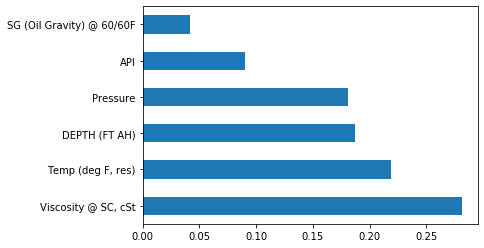

In [14]:
#let us try to visualize the most important features
feat_importances = pd.Series(gridsearch_rf.feature_importances_, index=X.columns)
feat_importances.nlargest(6).plot(kind='barh')

In [19]:
# Extract the small tree
import pydot
tree_small = gridsearch_rf.estimators_[5]
# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = X.columns, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('small_tree.dot')
graph.write_png('small_tree.png');

In [21]:
#now to prepare AdaBoost
estimator_ada = AdaBoostRegressor(random_state = 42)
params_ada = {'n_estimators': np.arange(40, 300, 10), "learning_rate": np.arange(0.01, 0.1, 0.01), "loss": ["linear", "square", "exponential"]}
gridsearch_ada = GridSearchCV(estimator=estimator_ada, cv=5, param_grid = params_ada, n_jobs = -1, scoring= "neg_mean_squared_error")
gridsearch_ada.fit(X, y)

GridSearchCV(cv=5, error_score=nan,
             estimator=AdaBoostRegressor(base_estimator=None, learning_rate=1.0,
                                         loss='linear', n_estimators=50,
                                         random_state=42),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]),
                         'loss': ['linear', 'square', 'exponential'],
                         'n_estimators': array([ 40,  50,  60,  70,  80,  90, 100, 110, 120, 130, 140, 150, 160,
       170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [22]:
gridsearch_ada.best_params_

{'learning_rate': 0.05, 'loss': 'linear', 'n_estimators': 40}

In [ ]:
#saving model and loading into the disk space
file_name = "ada_boost.pkl"
with open(file_name, 'wb') as file:
    pickle.dump(gridsearch_ada.best_estimator_, file)

In [11]:
#loading and predicting the model
gridsearch_ada =  pickle.load(open("ada_boost.pkl", "rb"))
mse_ada = mean_squared_error(y, gridsearch_ada.predict(X))
rmse_ada = sqrt(mse_ada)
mae_ada = mean_absolute_error(y, gridsearch_ada.predict(X))
r2_ada = r2_score(y, gridsearch_ada.predict(X))
print(f"The Values of the error of Adaptive Boosting(AdaBoost) with respect to the Truth values varies as follows \n 1. Mean Squared Error {mse_ada} \n 2. Root Mean Squared Error {rmse_ada} \n 3. Mean Absolute Error {mae_ada} \n 4. The R2 Score {r2_ada}")

The Values of the error of Adaptive Boosting(AdaBoost) with respect to the Truth values varies as follows 
 1. Mean Squared Error 5.0497814801721335 
 2. Root Mean Squared Error 2.247171884874883 
 3. Mean Absolute Error 1.4238424352112078 
 4. The R2 Score 0.9496222502274353
